In this assignment, you will analyze the bias/variance tradeoff in order to perform model selection. You will use the code we wrote in class and extend it to include an average over the test set datapoints.

- You will generate a dataset consisting of a independent variable $x$ and a dependent variable $y$ (targets), related by ground truth model $y=f(x)$ with $f(x)=x^2+sin(x)$. Generate $N=10.000$ training observations $x_i,y_i$ uniformly distributed along the interval $x\in[-x_{max},x_{max}]$ with $x_{max}=2$ using the following generative model
$$
y_i=f(x_i)+\epsilon_i
$$
The measurement noise is sampled from a gaussian distribution $\epsilon_i\sim {\cal N}(0,\sigma_\epsilon^2)$ with mean zero and standard deviation $\sigma_\epsilon=0.5$.
- Generate a test set consisting of a $N_{test}=100$ observations $x^{test}_i,y^{test}_i$, for $i=1,\ldots,N_{test}$ uniformly distributed in the interval $[x_{max},x_{max}+1]$.
- Visualize ground truth model, training observations, and test set.
- Your goal is to learn a function $\hat f(x)$ that best predicts the targets in the test set - namely, leads to the smallest generalization error. Compare several alternative models, within the class of polynomials of degree $d$: $
\hat f_d(x|w)=\sum_{i=0}^d w^{(d)}_i x^i$, where $w^{(d)}_i$ are the parameters to be learned using polynomial regression. Pick a range $d=0,\ldots,5$. 
- You will perform $a=1,\ldots,n_{exp}=1000$ experiments. For each experiment, you will create a new training set $S_{train}^a=[x_i,y_i]$ by randomly subsampling $N_{train}=0.01N$ of the original $N$ training observations, then fit each model $\hat f_d(x|w)$ to the training set $S_{train}^a$, to learn the parameters $w^{(d)}_i(a)\equiv w^{(d)}_i(S_{train}^a)$. 
- For each experiment $a$ with learned parameters $w^{(d)}_i(a)$, you will then make a prediction for all points in the test set $y^{test}_i=\hat f(x^{test}_i|w^{(d)}_i(a)$). Crucially, the learned parameters $w^{(d)}_i(a)$ and thus the prediction $y^{test}_i$ will be different in the different experiments: they are functions of the training set  $S_{train}^a$.
- For each experiment $a$ and each polynomial model $d$, estimate the average squared training error 
$$err_{train}(d,a)={1\over N_{train}}\sum_{i\in N_{train}}[\hat f_d(x_i|w^{(d)}(a))-y_i]^2 \ ,$$
the average squared test error 
$$err_{test}(d,a)={1\over N_{test}}\sum_{i\in N_{test}}[\hat f_d(x^{test}_i|w^{(d)}(a))-y^{test}_i]^2 \ ,$$
and the squared irreducible error $err_{\epsilon}=\sigma_\epsilon^2$, and also the average bias squared and the variance of the predictions in the test set. For each $d$, calculate the mean and standard deviation of all these quantities across experiments.
- Plot their mean and standard deviation as a function of $d$, and verify that the test error satisfies the bias/variance tradeoff.
- Which value of $d$ gives the lowest average test error? That will be the polynomial model that best approximates the ground truth model $f(x)$.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

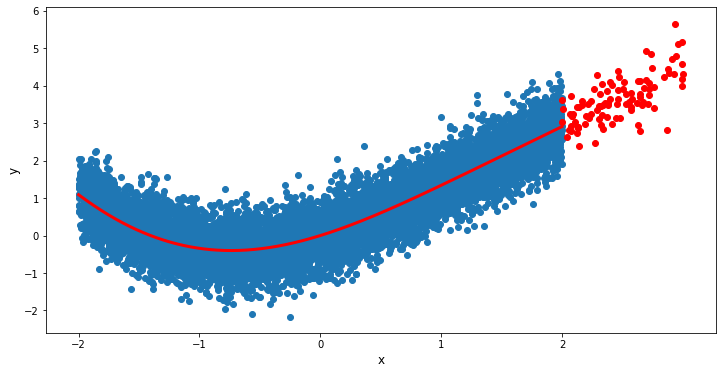

In [9]:


# define ground truth model f(x)
def f(x):
    return np.sin(x)+0.5*x**2

#our class of models to fit: polynomials of degree d
def f_hat(x, w):
    d = len(w) - 1
    return np.sum(w * np.power(x, np.expand_dims(np.arange(d, -1, -1), 1)).T, 1)

# training (x,y) set consists of N observations in the interval [-x_max,x_max]
N = 10000 # total population
x_max = 2
x = x_max * (2*np.random.rand(N)-1)
# measurement noise
sigma_epsilon = 0.5
epsilon = sigma_epsilon * np.random.randn(N)
# training set (x,y)
y = f(x) + epsilon
# test set
n_test = 100
x_test = x_max + np.random.rand(n_test) 
epsilon = sigma_epsilon * np.random.randn(n_test)
y_test = f(x_test) + epsilon

#plot
plt.figure(figsize=(12, 6))
x_range = np.linspace(-x_max, x_max, 1000)
# ground truth model
plt.plot(x_range, f(x_range), 'r', linewidth=3.0)
# training set
plt.scatter(x, y)
# test set
plt.scatter(x_test, y_test, c='r')
#
plt.xlabel('x', size=12)
plt.ylabel('y', size=12)
plt.xticks(np.arange(-x_max, x_max + 1))
plt.show()



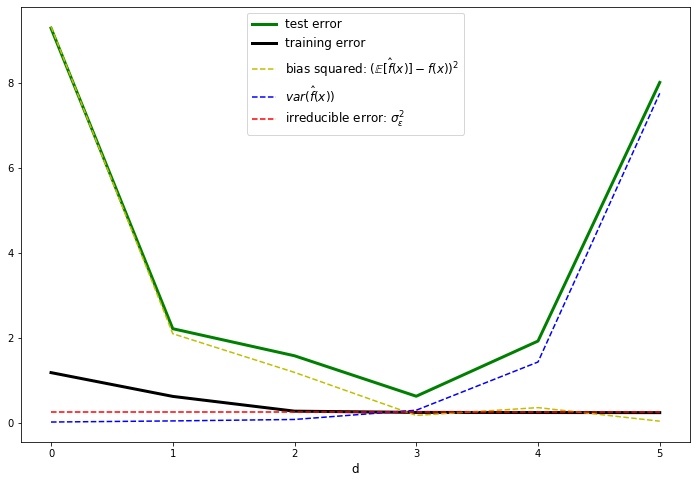

In [11]:
n_exp = 1000
n = int(.01 * N)

d_arr = [0, 1, 2, 3, 4, 5]

train_squared_error = np.zeros((len(d_arr), n_exp))
y_hat_test = np.zeros((len(d_arr), n_exp, n_test))
for r in range(n_exp):
    idx = np.random.permutation(N)[:n]
    x_train, y_train = x[idx], y[idx]
    for k in range(len(d_arr)):
        d = d_arr[k]
        w = np.polyfit(x_train, y_train, d)
        train_squared_error[k, r] = np.mean((y_train - f_hat(x_train, w)) ** 2)
        y_hat_test[k, r, :] = f_hat(x_test, w)

test_squared_error = np.mean((y_hat_test - y_test) ** 2, 1)
bias_squared = (np.mean(y_hat_test, 1) - f(x_test)) ** 2
var_y_hat_test = np.var(y_hat_test, 1)

plt.figure(figsize=(12, 8))
plt.plot(d_arr, np.mean(test_squared_error, 1), 'g', linewidth=3.0)
plt.plot(d_arr, np.mean(train_squared_error, 1), 'k', linewidth=3.0)
plt.plot(d_arr, np.mean(bias_squared, 1), 'y--')
plt.plot(d_arr, np.mean(var_y_hat_test, 1), 'b--')
plt.plot(d_arr, (sigma_epsilon ** 2) * np.ones_like(d_arr), 'r--')
# plt.plot(d_arr, np.mean(bias_squared + var_y_hat_test + sigma_epsilon ** 2, 1), 'm--')
plt.xticks(d_arr)
plt.xlabel('d', size=12)
plt.legend(['test error', 'training error', r'bias squared: $(\mathbb{E}[\hat{f}(x)] - f(x))^2$',
            r'$var(\hat{f}(x))$', r'irreducible error: $\sigma_\epsilon^2$'], loc='upper center', fontsize=12)
plt.show()
plt.savefig('figs/Assignment3_biasvar.pdf', bbox_inches='tight')
